# TUTORIAL 6 - SURROGATE GRADIENT DESCENT IN A CONVOLUTIONAL SNN

The purpose of this tutorial is to demonstrate how to modify gradient descent to overcome the dead-neuron problem, 
using SnnTorch's surrogate gradient functionality. By the end of this tutorial, you have built and trained a convolutional 
SNN on MNIST dataset. 

Lets install required pakckages

In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

/tmp/ipykernel_124430/3569606770.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


## SURROGATE GRADIENT DESCENT
[Tutorial 5](tutorial-5-Gradient-Descent-in-SNNs.ipynb) demostrated the **dead neuron problem**. This arises beacuse the activation neuron operates as a heaviside step function over the membrane potential. The derivative of the heaviside step function in the dirac delta function, which is zero everywhere except at zero. 
To overcome this problem, we can use a **surrogate gradient**. A surrogate gradient is a smooth approximation of the derivative of the activation function. This allows us to use gradient descent to train SNNs. The surrogate gradient is only used during the backward pass, while the forward pass uses the original activation function (heaviside step function).

$$
S[t] = \Theta(U[t] - U_{\text{thr}})
\tag{1}
$$

$$
\frac{\partial S[t]}{\partial U[t]} = \delta(U[t] - U_{\text{thr}}) \in \left\{0, \infty\right\}
\tag{2}
$$

In Tutorial 5, we use $arctan$ as a surrogate gradient. In this tutorial, we will use the **sigmoid** function as a surrogate gradient. The surrogate function must be shifted such that they are centered at the threshold $U_{\text{thr}}$. 

Lets define the overdrive of the membrane potential as: $U_{\text{OD}} = U - U_{\text{thr}}$
The surrogate function we will use is:
$$
\tilde{S}[t] = \frac{U_{OD}}{1+k|U_{OD}|}
\tag{3} 
$$

And the derivative is:
$$
\frac{\partial \tilde{S}[t]}{\partial U[t]} = \frac{1}{(1+k|U_{OD}|)^2}
\tag{4}
$$

Where $k$ modulates how smooth the surrogate function is. A larger $k$ makes the surrogate function closer to the heaviside step function, while a smaller $k$ makes it smoother.

To summarize:

+ **Forward Pass**
  + Determine $S$ (spikes) using the Heavside function in equation (1)
  + Store $U$ for later use during backward pass.

+ **Backward Pass**
  + Pass $U$ into eq (4) to calculate the derivative term.

### Implementing Surrogate Gradient in SNNs
For learning purposes, we will implement the *LIF* neuron model with a sigmoid surrogate gradient. Later on in this tutorial, we will simply use the built-in SnnTorch surrogate gradient functionality.

In [3]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySigmoidSurrogate(nn.Module):
    def __init__(self, beta:float, threshold:float=1.0, k:float=25.0):
        """Leaky Integrate-and-Fire neuron with Sigmoid surrogate gradient.
        Args:
            beta (float): Leaky parameter. Should be between 0 and 1.
            threshold (float, optional): Neuron firing threshold. Defaults to 1.0.
            k (float, optional): Slope of the sigmoid surrogate gradient. Defaults to 25.0.
        """
        super(LeakySigmoidSurrogate, self).__init__()
        self.beta = beta    # decay rate
        self.threshold = threshold  # spiking threshold
        self.k = k            # slope of surrogate (sigmoid) gradient

        self.surrogate_func = self.FastSigmoid.apply

    def init_leaky(self, batch_size:int, num_neurons:int, device):
        """Initialize the leaky neuron state variables.
        Args:
            batch_size (int): Batch size.
            num_neurons (int): Number of neurons in the layer.
            device (torch.device): Device to place the tensors on.
        Returns:
            torch.Tensor: Initial membrane potential tensor of shape (batch_size, num_neurons).
        """
        
        return torch.zeros(batch_size, num_neurons, device=device)
        

    # Creating the surrogate function.
    # Forward and backward passes are defined here.
    @staticmethod
    class FastSigmoid(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem:torch.Tensor, k:float=25.0)->torch.Tensor:
            # Heaviside step function
            ctx.save_for_backward(mem)    # store the membrane potential for use in backward pass      
            ctx.k = k
            return (mem > 0).float()

        @staticmethod
        def backward(ctx, grad_output:torch.Tensor)->torch.Tensor:
            # Surrogate gradient based on sigmoid function
            (mem, ) = ctx.saved_tensors # retrieve saved tensors (membrane potential) during forward pass
            grad_input = grad_output.clone()
            grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2 # Gradient of sigmoid 
            return grad, None

Thats it! All we had to do was to create a class that inherits from `torch.autograd.Function` and implement the `forward` and `backward` methods based on the explanations above.

Thankfully, SnnTorch has built-in module called `ssn.surrogate` that allows us to easily use surrogate gradients. Lets see how to use it.

In [4]:
spike_grad = surrogate.fast_sigmoid(slope=25) # "slope" parameter corresponds to "k" in above
beta = 0.5 # leaky parameter

lif1 = snn.Leaky(beta=beta, threshold=1.0, spike_grad=spike_grad)

And that's it! Other surrogate functions are also available in the `ssn.surrogate` module. Here is a link to the [full list in the documentation](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html):

## 2. SETTING UP THE CONVOLUTIONAL SNN (CSNN)
Now lets build a full convolutional SNN using `snnTorch` surrogate gradient functionality. 
Lets list all the steps we need to take:
+ Dataloader
+ Input transforms
+ Define the CSNN architecture
+ Define the loss function and optimizer
+ Training loop
+ Evaluation loop
+ Plotting results

We will go through each step one by one.

### 2.1 Dataloader
Load the MNIST dataset

In [5]:
# dataloaders parameters
batch_size = 128
data_path = '/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### 2.2 Input transforms
The basic transforms we need is to resize the images to 28x28, convert them to grayscale, and convert them to tensors. Finally, we will normalize the images to have zero mean and unit variance.

```python

In [6]:
transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transforms)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transforms)

# Create the dataloaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

### 2.2 Define the CSNN architecture
The convolutional network we will use is:
12C5-MP2-64C5-MP2-1024FC10

+ 12C5: a 5x5 conv kernel with 12 output channels
+ MP2: 2x2 max pooling
+ 64C5: a 5x5 conv kernel with 64 output channels
+ MP2: 2x2 max pooling
+ 1024FC10: a fully connected layer that maps 1024 neurons to 10 outputs

Two important things to note:
+ **NUM of STEPS**: The number of time steps during a forward pass.
+ **RESET MEMBRANE POTENTIAL**: The membrane potential of the neurons must be reset to zero at the beginning of each forward pass.


In [10]:

class CSNN(nn.Module):
    def __init__(self, beta:float=0.5, slope:float=25.0, num_steps:int=25):
        super().__init__()

        self.num_steps = num_steps
        
        # Initialize the layers
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # 1 input channel (grayscale), 12 output channels, 5x5 kernel
        self.lif1 = snn.Leaky(beta=beta, threshold=1.0, spike_grad=surrogate.fast_sigmoid(slope=slope))
        self.pool1 = nn.MaxPool2d(2)  # 2x2

        self.conv2 = nn.Conv2d(12, 64, kernel_size=5)  # 12 input channels, 64 output channels, 5x5 kernel
        self.lif2 = snn.Leaky(beta=beta, threshold=1.0, spike_grad=surrogate.fast_sigmoid(slope=slope))
        self.pool2 = nn.MaxPool2d(2)  # 2x2

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 10)  # Fully connected layer
        self.lif3 = snn.Leaky(beta=beta, threshold=1.0, spike_grad=surrogate.fast_sigmoid(slope=slope))

    def forward(self, x:torch.Tensor, num_steps:int=1):

        # Initialies hidden states and inputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        mem_out_rec = []
        spk_out_rec = []
        
        for step in range(num_steps):
            cur1 = self.pool1(self.conv1(x))
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.pool2(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)

            flattened = self.flatten(spk2)
            cur3 = self.fc1(flattened)
            spk3, mem3 = self.lif3(cur3, mem3)

            mem_out_rec.append(mem3)
            spk_out_rec.append(spk3)

        return torch.stack(spk_out_rec), torch.stack(mem_out_rec)

## 2.3. Loss function
In the previous tutorial, the Cross Entropy loss between the membrance potential of the output layer and the target labels was used to train the network. This time, to **total** number of spikes from each neuron will be used to calculate the Cross Entropy instead. 
In `ssnTorch`, the module `ssn.functional` (analogous to `torch.nn.functional`) has a collection of loss functions that can be applied to spikes and/or membrane potentials. 
The approach below applies the cross entroy loss to the output spikes count.

In [12]:
loss_fn = SF.ce_rate_loss()


### 3.3. Training loop


In [15]:
net = CSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 5
num_steps = 25
test_acc_rec = []

# Epoch Loop
for epoch in range(num_epochs):
    epoch_loss = []
    net.train()
    # Batch Loop
    for data, targets in iter(train_loader):

        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec, mem_rec = net(data, num_steps=num_steps)
        
        # Compute the loss
        train_loss = loss_fn(spk_rec, targets)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Store loss of batch
        epoch_loss.append(train_loss.item())

    # Compute average loss for epoch
    avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

    # Testing loop
    with torch.no_grad():
        net.eval()
        test_loss = []
        accuracy = []
        for data, targets in iter(test_loader):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            spk_rec, mem_rec = net(data, num_steps=num_steps)

            # Compute the loss
            test_loss.append(loss_fn(spk_rec, targets).item())

            # Compute batch accuracy
            acc = SF.accuracy_rate(spk_rec, targets)
            accuracy.append(acc)
        avg_test_loss = sum(test_loss) / len(test_loss)
        print(f"Test Loss: {avg_test_loss:.4f}")
        avg_acc = sum(accuracy) / len(accuracy)
        test_acc_rec.append(avg_acc)
        print(f"Test Accuracy: {avg_acc*100:.2f}%")


Epoch 1/5, Loss: 1.5334
Test Loss: 1.4873
Test Accuracy: 97.29%
Test Loss: 1.4873
Test Accuracy: 97.29%
Epoch 2/5, Loss: 1.4892
Epoch 2/5, Loss: 1.4892
Test Loss: 1.4857
Test Accuracy: 98.12%
Test Loss: 1.4857
Test Accuracy: 98.12%
Epoch 3/5, Loss: 1.4857
Epoch 3/5, Loss: 1.4857
Test Loss: 1.4828
Test Accuracy: 97.43%
Test Loss: 1.4828
Test Accuracy: 97.43%
Epoch 4/5, Loss: 1.4847
Epoch 4/5, Loss: 1.4847
Test Loss: 1.4854
Test Accuracy: 96.80%
Test Loss: 1.4854
Test Accuracy: 96.80%
Epoch 5/5, Loss: 1.4824
Epoch 5/5, Loss: 1.4824
Test Loss: 1.4827
Test Accuracy: 97.89%
Test Loss: 1.4827
Test Accuracy: 97.89%


## 4. RESULTS
`snnTorch` has a built-int plotting function: `splt.spike_count` that can help visualize the spike counts of each layer, for a given input image.
Lets load a sample image from the test dataset and plot the spike counts of the output layer.

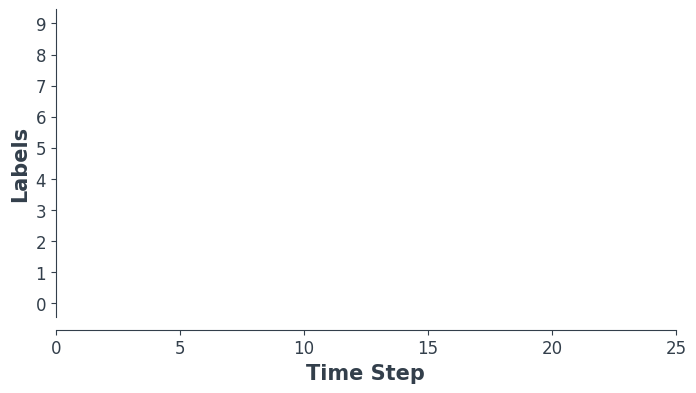

In [39]:
from IPython.display import HTML

sample_data, sample_targets = next(iter(test_loader))
sample_data = sample_data.to(device)
sample_targets = sample_targets.to(device)

spk_rec, mem_rec = net(sample_data, num_steps=num_steps)

idx = 56
fig,ax = plt.subplots(1,1,figsize=(8,4))
labels = ['0','1','2','3','4','5','6','7','8','9']

anim = splt.spike_count(spk_rec[:,idx].detach().cpu(), fig, ax ,labels=labels, 
                        animate=True, interpolate=4)
HTML(anim.to_html5_video())

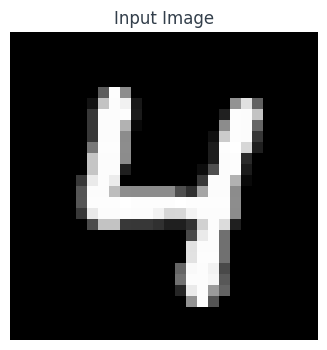

True label: 4


In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.imshow(sample_data[idx].cpu().squeeze(), cmap='gray')
ax.set_title('Input Image')
ax.axis('off')
plt.show()

print(f'True label: {sample_targets[idx].item()}')